# resonator-dds

This notebook tests the functionality of the resonator_dds core  

The overlay looks like 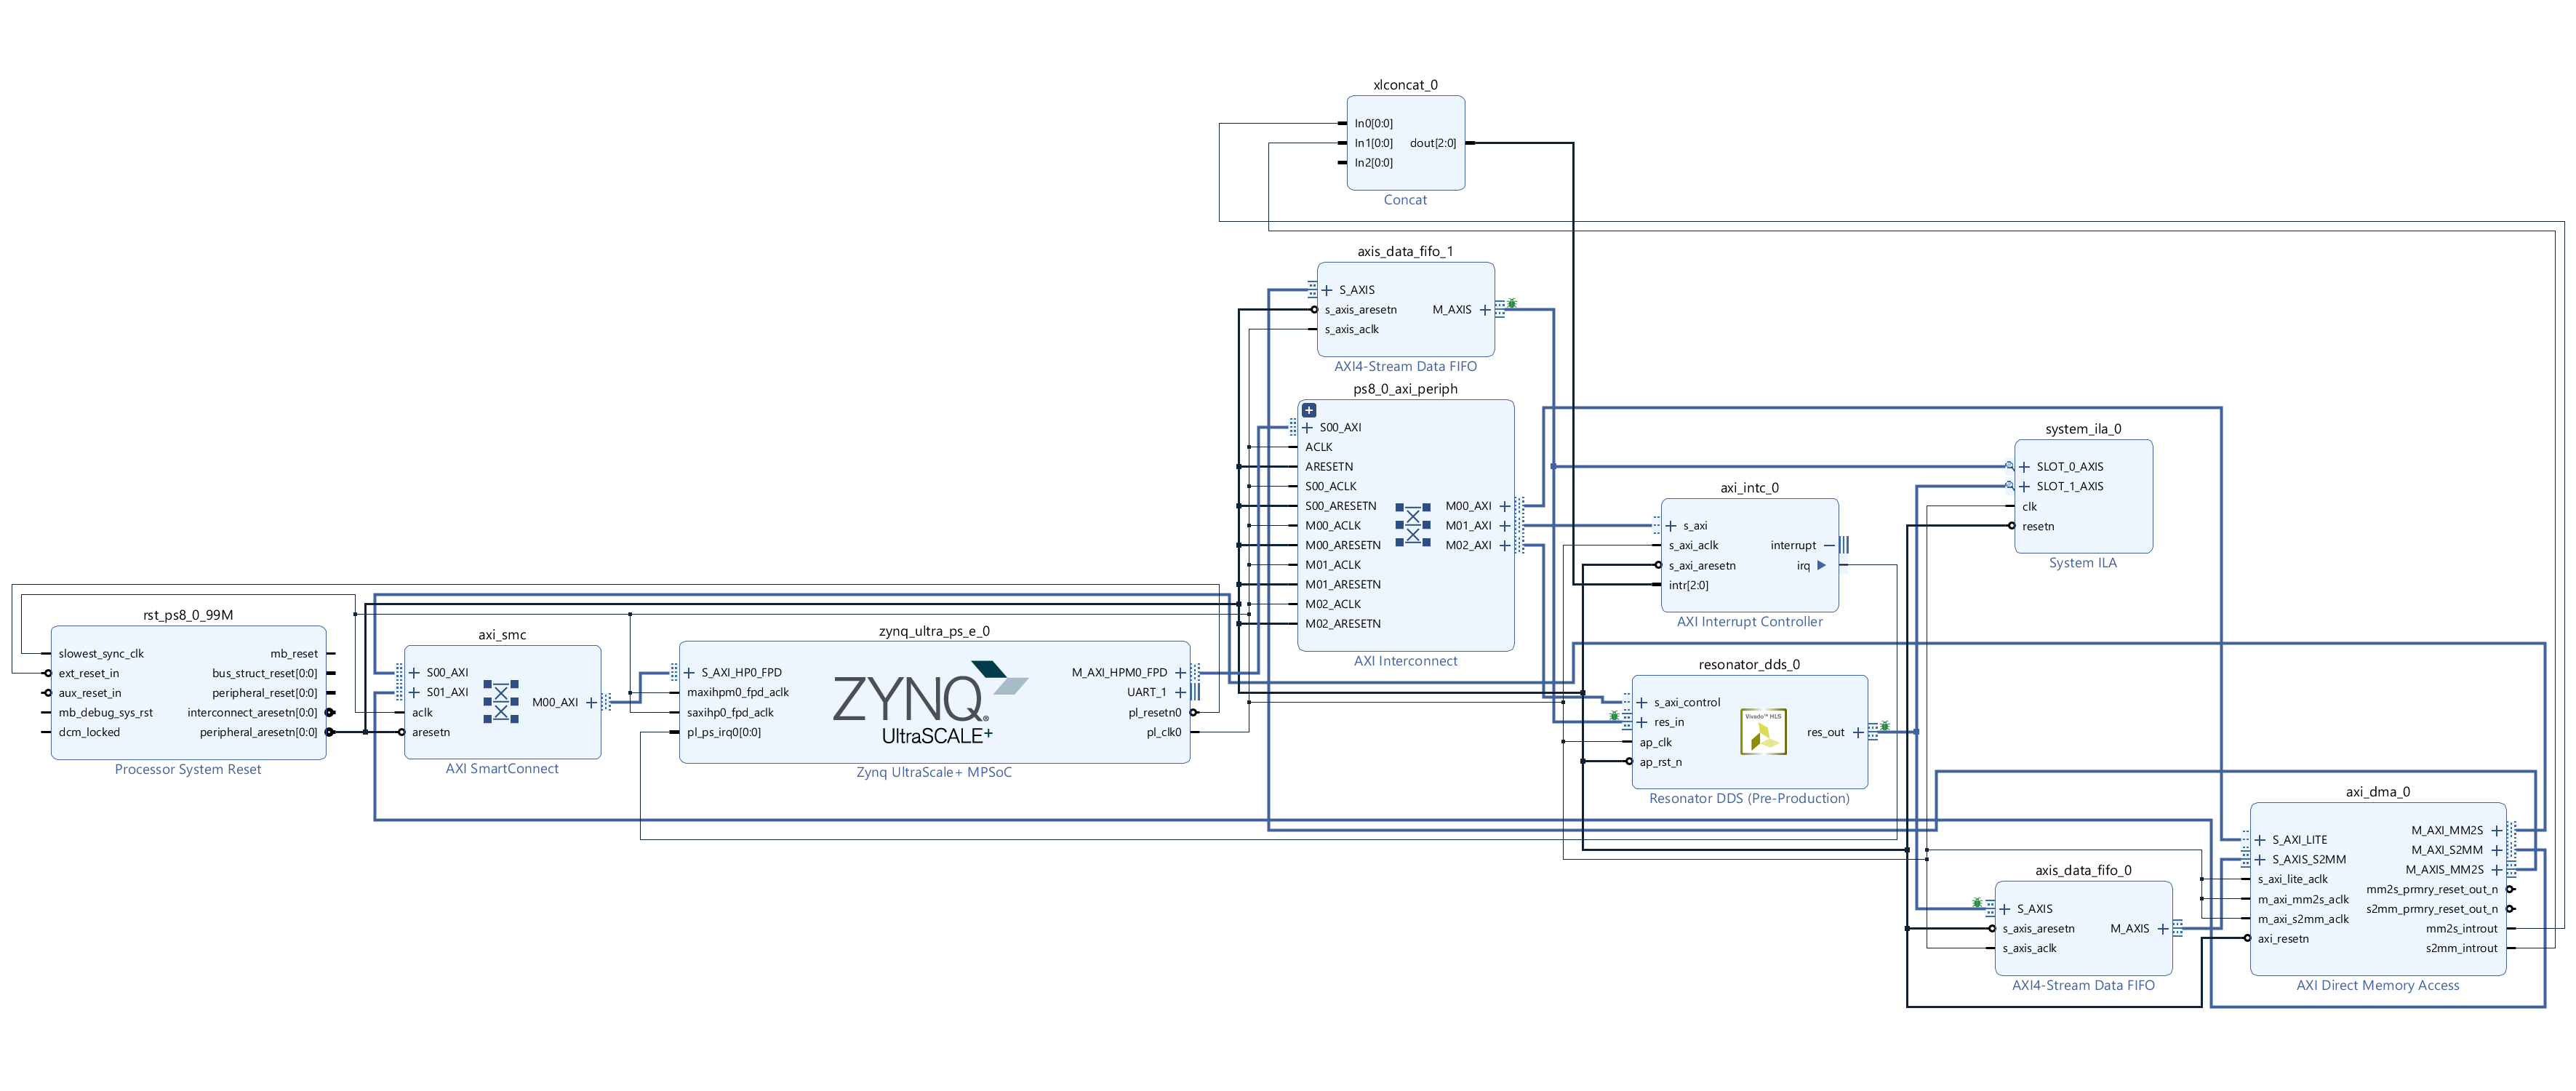

## 1. Instantiating an overlay
With the following overlay bundle present in the `overlays` folder, users can instantiate the overlay easily.

*  A bitstream file (\*.bit).
*  A tcl file (\*.tcl), or an hwh file (\*.hwh).
*  A python class (\*.py).

For example, an overlay called `base` can be loaded by:
```python
from pynq.overlays.base import BaseOverlay
overlay = BaseOverlay(SOME PATH)
```
Users can also use the absolute file path of the bitstream to instantiate the overlay.

In the following cell, we get the current bitstream loaded on PL, and try to download it multiple times. Then we can check the download timestamp for this overlay.

In [1]:
import numpy as np
from fpbinary import FpBinary, OverflowEnum, RoundingEnum
from pynq import DefaultIP
from itertools import tee
import matplotlib.pyplot as plt

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)


class ResonatorDDSIP(DefaultIP):
    toneinc_offset = 0x1000
    phase0_offset = 0x2000
    def __init__(self, description):
        # // 0x1000 ~
        # // 0x1fff : Memory 'toneinc_V' (256 * 128b)
        # //          Word 4n   : bit [31:0] - toneinc_V[n][31: 0]
        # //          Word 4n+1 : bit [31:0] - toneinc_V[n][63:32]
        # //          Word 4n+2 : bit [31:0] - toneinc_V[n][95:64]
        # //          Word 4n+3 : bit [31:0] - toneinc_V[n][127:96]
        # // 0x2000 ~
        # // 0x2fff : Memory 'phase0_V' (256 * 128b)
        # //          Word 4n   : bit [31:0] - phase0_V[n][31: 0]
        # //          Word 4n+1 : bit [31:0] - phase0_V[n][63:32]
        # //          Word 4n+2 : bit [31:0] - phase0_V[n][95:64]
        # //          Word 4n+3 : bit [31:0] - phase0_V[n][127:96]
        super().__init__(description=description)

    bindto = ['MazinLab:mkidgen3:resonator_dds:0.4']

    @staticmethod
    def _checkgroup(group_ndx):
        if group_ndx<0 or group_ndx>255:
            raise ValueError('group_ndx must be in [0,255]')
            
    def read_group(self, offset, group_ndx):
        """Read the numbers in group from the core and convert them from binary data to python numbers"""
        self._checkgroup(group_ndx)
        signed = offset==self.toneinc_offset
        vals=[self.read(offset+16*group_ndx+4*i) for i in range(3)]
        ret = [float(FpBinary(1, 15, signed=signed, bit_field=(v>>(16*i))&0xffff)) 
               for v in vals for i in (0,1)]
        #print(f"Read {bin(vals[0]&0xffff)} from the first address.")
        return ret

    def write_group(self, offset, group_ndx, group):
        """Convert the numbers in the group from python data to binary data and load it into the core"""
        self._checkgroup(group_ndx)
        if len(group)!=8:
            raise ValueError('len(group)!=8')
        signed = offset==self.toneinc_offset
        bits=0
        fixedgroup = [FpBinary(int_bits=1, frac_bits=15, signed=signed, value=g) for g in group]
        for i, (g0,g1) in enumerate(zip(*[iter(fixedgroup)] * 2)):
            bits|= ((g1.__index__()<<16) | g0.__index__()) <<(32*i)
        data = bits.to_bytes(32, 'little', signed=False)
        #print(f"Writing {bin(bits&0xffff)} to the first address.")
        self.write(offset+16*group_ndx, data)

    def toneinc(self, res):
        """ Retrieve the tone increment for a particular resonator """
        return self.read_group(self.toneinc_offset, res//8)[res%8]
    
    def phase0(self, res):
        """ Retrieve the phase offset for a particular resonator """
        return self.read_group(self.phase0_offset, res//8)[res%8]

    @property
    def toneincs(self):
        return [v for g in range(256) for v in self.read_group(self.toneinc_offset, g)]

    @toneincs.setter
    def toneincs(self, toneincs):
        if len(toneincs)!=2048:
            raise ValueError('len(toneincs)!=2048')
        if min(toneincs)<-1 or max(toneincs)>=1:
            raise ValueError('Tone increments must be in [-1,1)')
        for i in range(256):
            self.write_group(self.toneinc_offset, i, toneincs[i*8:i*8+8])
            
    @property
    def phase0s(self):
        return [v for g in range(256) for v in self.read_group(self.phase0_offset, g)]

    @phase0s.setter
    def phase0s(self, phase0s):
        if len(phase0s)!=2048:
            raise ValueError('len(phase0s)!=2048')
        if min(phase0s)<0 or max(phase0s)>1:
            raise ValueError('Phase offsets must be in [0,1]')
        for i in range(256):
            self.write_group(self.phase0_offset, i, phase0s[i*8:i*8+8])
            
def dma_status(dma):
    #dma.recvchannel.idle,dma.sendchannel.idle
    msg=("DMA:\n"
         " MM2s\n"
         f" Idle:{dma.sendchannel.idle}\n"
         f" MM2S_DMASR (status):{hex(dma.mmio.read(4))}\n"
         f" MM2S_SA (ptr) :{hex(dma.mmio.read(24))}\n"
         f" MM2S_LENGTH (len):{dma.mmio.read(40)}\n"
         " S2MM\n"
         f" Idle:{dma.recvchannel.idle}\n"
         f" S2MM_DMASR (status):{hex(dma.mmio.read(52))}\n"
         f" S2MM_DA (ptr) :{hex(dma.mmio.read(72))}\n"
         f" S2MM_LENGTH (len):{dma.mmio.read(88)}")
    print(msg)

In [2]:
from pynq import PL
from pynq import Overlay
from pynq import allocate

n_res = 2048
n_bin = 4096
n_cycle = 256
ol = Overlay('/home/xilinx/overlayfiles/test_dds/test_dds.bit')
ol.download()
print(f"PL Bitfile: {PL.bitfile_name}\n  {PL.timestamp}\n"
      f"Overlay timestamp: {ol.timestamp}  Loaded: {ol.is_loaded()}")

PL Bitfile: /home/xilinx/overlayfiles/test_dds/test_dds.bit
  2020/2/18 23:44:38 +307862
Overlay timestamp: 2020/2/18 23:44:38 +307862  Loaded: True


## 3. Overlay Parts


In [3]:
ol.ip_dict.keys()

dict_keys(['axi_dma_0', 'resonator_dds_0', 'axi_intc_0'])

In [4]:
core = ol.resonator_dds_0
dma = ol.axi_dma_0

### Configure the tone increments and phase offsets

Tone increments: 2048 `ap_fixed<16, 1, AP_RND_CONV, AP_WRAP>`

Phase offsets: 2048 `ap_ufixed<16, 1, AP_RND_CONV, AP_WRAP>`

In [5]:
print('Writing null phase0...')
core.phase0s=np.zeros(n_res)
for g in (0,255):
    print(f'Reading phase offset group {g}',core.read_group(core.phase0_offset, g))

Writing null phase0...
Reading phase offset group 0 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Reading phase offset group 255 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Tone increments are a bit more complicated. Bins are ±1MHz, and overlapped so a resonator will always be within 500kHz of the bin center and have a corresponding increment. Here we don't care that resonators are at a specific frequency, in general the offset will be the difference in its assigned bin' central frequency and the resonators frequency.

Resonators have a bandwidth and generally if they are on top of each other we can not read them out in a meaningful manner (similarly if there are too many in a bin we can't use the bin) so lets place a n_tones into a bin with offset_frequencies.

Within the core the tone offset becomes a phase increment, where ±2 MHz would correspond to ±1.

In [6]:
#-250kHz, lane 0 group 0
#100kHz, lane 0 group 1
#30kHz, lane 2 group 1
#35kHz, lane 0 group 255
tone_list=np.array([-0.85e6, 0.1e6, 0.03e6, 0.035e6])
tone_placement = (0,8,10,2040)
tone_amp=np.array([1/2048,1/2048,1/2048,1/2048])*100
tone_incs=tone_list/2.048e6
amplitudes = np.zeros(n_res)
tones=np.zeros(n_res)
for i,t,a in zip(tone_placement, tone_list, tone_amp):
    tones[i]=t
    amplitudes[i]=a

In [7]:
print('Writing tone increments...')
core.toneincs=-2*tones/2.048e6  # The core expects normalized increments
for g in (0,1,255):
    print(f'Reading toneinc group {g}',core.read_group(core.toneinc_offset, g))

Writing tone increments...
Reading toneinc group 0 [0.830078125, 0.0, 0.0, 0.0, 0.0, 0.0]
Reading toneinc group 1 [-0.09765625, 0.0, -0.029296875, 0.0, 0.0, 0.0]
Reading toneinc group 255 [-0.0341796875, 0.0, 0.0, 0.0, 0.0, 0.0]


### Generate and feed a stream

Both the resonator packets and the downconverted packets are $8kB = 256~cycles \cdot256~bits/cycle$, probably I0I1...I7Q0...Q7. So that is 4096 16 bit numbers, note that operations like input_buffer[5:]=999 will kill the kernel (at least sometimes)!

We need to send two packets  to ensure we drive the last transfer of the first packet all the way through the core (the core latency is ~30).

In [8]:
input_buffer = allocate(shape=(n_res*2,), dtype=np.uint16)
output_buffer = allocate(shape=(n_res*2,), dtype=np.uint16)

First create a timeseries of IQ values for a bin in it.
A 1Hz signal would have 2M samples

In [9]:
def waveform(freq, amp, func, n):
    phase=np.arange(n)*2*np.pi/2.048e6
    return amp*func(freq*phase)

samples=100  # Should be even because I'm lazy later
packets=np.zeros((samples,n_res),dtype=np.complex64)
packets_out=np.zeros((samples,n_res),dtype=np.complex64)
for i,(tone, amp) in enumerate(zip(tones, amplitudes)):
    packets[:,i].real+=waveform(tone, amp, np.cos, samples)
    packets[:,i].imag+=waveform(tone, amp, np.sin, samples)

...and some functions to convert them two and from the correct data format.

In [10]:
def packet_to_buffer(packet):
    """packet is an np.array(n_res,dtype=np.complex64)"""
    ibits=[FpBinary(int_bits=1, frac_bits=15, signed=True, value=x).__index__() for x in packet.real]
    qbits=[FpBinary(int_bits=1, frac_bits=15, signed=True, value=x).__index__() for x in packet.imag]
    #buffer (probably) needs to be i0-7q0-7...
    data=np.zeros(2*n_res, dtype=np.uint16)
    for i in range(8):
        data[i::16] = ibits[i::8]
        data[i+8::16] = qbits[i::8]
    return data

def packet_from_buffer(buffer):
    ibits=np.zeros(n_res, dtype=np.uint16)
    qbits=np.zeros(n_res, dtype=np.uint16)
    for i in range(8):
        ibits[i::8]=buffer[i::16]
        qbits[i::8]=buffer[i+8::16]
    
    packet=np.zeros(n_res, dtype=np.complex64)
    packet.real=[float(FpBinary(int_bits=1, frac_bits=15, signed=True, bit_field=int(x))) for x in ibits]
    packet.imag=[float(FpBinary(int_bits=1, frac_bits=15, signed=True, bit_field=int(x))) for x in qbits]

    return packet

Look at some of the tones are roundtrip them t make sure everything is working. We expect to see quantization effects!

In [11]:
for i in tone_placement:
    print(packets[:3,i])

[ 0.04882812+0.j         -0.04203452-0.02484522j  0.02354413+0.04277686j]
[ 0.04882812+0.j          0.04654815+0.01474638j  0.03992113+0.02811563j]
[ 0.04882812+0.j          0.04862146+0.00448774j  0.04800320+0.00893749j]
[ 0.04882812+0.j          0.04854690+0.00523303j  0.04770645+0.01040578j]


In [12]:
r=0  # Res to look at
s=1  # Sample to look at
buf=packet_to_buffer(packets[s])
pak=packet_from_buffer(buf)
print(f'Value: {packets[s,r]}\nbits: {buf[[(r//8)*16+r%8,(r//8)*16+r%8+8]]}\nRoundtrip: {pak[r]}')

Value: (-0.04203451797366142-0.024845222011208534j)
bits: [64159 64722]
Roundtrip: (-0.042022705078125-0.02484130859375j)


Then feed them through the core...

In [13]:
for i in range(0,packets.shape[0]):
    input_buffer[:]=packet_to_buffer(packets[i])
    dma.sendchannel.transfer(input_buffer)
    dma.sendchannel.wait()
    if i>0:
        dma.recvchannel.transfer(output_buffer)
        dma.recvchannel.wait()
        packets_out[i-1]=packet_from_buffer(output_buffer)

### Look at the results

Pull out the data from the input tones and exclude data from the very last cycle (which doesn't make it all the way through the core and back into RAM).

In [14]:
out_data=packets_out[:-1,tone_placement]  # last packet doesn't make it out

In [21]:
def plot_out_data(out_data):
    plt.subplot(2,1,1)
    plt.plot(np.angle(out_data)*180/np.pi,'.')
    plt.ylabel('Angle (deg)')
    plt.subplot(2,1,2)
    plt.plot(np.abs(out_data)/tone_amp,'.')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude/Expected')

Create a plot of the angle of each tone as a function of time. This shoudl be constant and match each tone's phase0*180/pi. Also create a plot of the amplitude of the tone, which should match the input amplitude. 

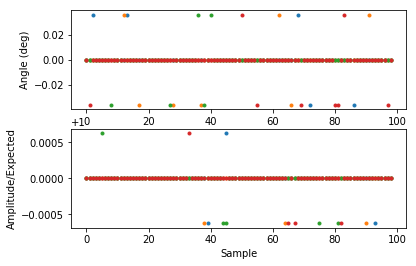

In [25]:
plot_out_data(out_data)

Print out the change in phase w.r.t sample for each tone. We expect this to be 0 and see only small single cycle phase excursions followed by corrections.

In [26]:
for d in out_data.T:
    print(np.around(np.diff(np.angle(d)*180/np.pi),decimals=6))
    print('')

[ 0.       0.03581 -0.03581  0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.03581 -0.03581  0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.03581 -0.03581  0.       0.
 -0.03581  0.03581  0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.      -0.03581  0.03581  0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.       0.     ]

[ 0.       0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.03581 -0.03581  0.       0.       0.      -0.03581
  0.0